### Model preparation

In [1]:
import torch
import torch.nn as nn
from PIL import Image
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from torchvision.models import densenet121, densenet169
from torch.utils.data import Dataset
from torchvision import transforms

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv(x)
        return self.sigmoid(x)

class CBAM(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(channels, reduction)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x
    
class DenseNet121WithAttention(nn.Module):
    def __init__(self, num_classes=1000):
        super(DenseNet121WithAttention, self).__init__()
        self.base = densenet121().features
        self.cbam = CBAM(channels=1024, reduction=8, kernel_size=11) 
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.base(x)
        x = self.cbam(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

num_classes = 10

model = DenseNet121WithAttention(num_classes=num_classes)

model.classifier = nn.Linear(model.classifier.in_features, num_classes)

'''
model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, 512),
    nn.ReLU(),
    nn.Dropout(p=0.3),   # Dropout layer
    nn.Linear(512, num_classes)
)
'''


'\nmodel.classifier = nn.Sequential(\n    nn.Linear(model.classifier.in_features, 512),\n    nn.ReLU(),\n    nn.Dropout(p=0.3),   # Dropout layer\n    nn.Linear(512, num_classes)\n)\n'

### Dataset preparation

In [2]:
class SpectrogramDataset(Dataset):
    def __init__(self, dataframe=None, csv_file=None, root_dir=None, transform=None, label_map=None):
        if dataframe is not None:
            self.annotations = dataframe.reset_index(drop=True)
        elif csv_file is not None:
            self.annotations = pd.read_csv(csv_file)
        else:
            raise ValueError("This should be either dataframe or csv!")

        self.root_dir = root_dir
        self.transform = transform
        self.label_map = label_map or self._build_label_map()

    def _build_label_map(self):
        labels = self.annotations['genre'].unique()
        return {label: idx for idx, label in enumerate(sorted(labels))}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        filename = self.annotations.iloc[idx, 0]
        subfolder = filename.split('.')[0]
        filename = filename[:-4] + '.png'
        img_name = os.path.join(self.root_dir, subfolder, filename)

        image = Image.open(img_name).convert('RGB')
        label_str = self.annotations.iloc[idx, 1]
        label = self.label_map[label_str]

        if self.transform:
            image = self.transform(image)

        return image, label


In [3]:
'''
from sklearn.model_selection import train_test_split
csv_file = 'project_data/tracks.csv'
df = pd.read_csv(csv_file)
df = df.sample(frac=1).reset_index(drop=True)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['genre'])
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['genre'])

train_df.to_csv('densenet_dataset_split/train.csv', index=False)
valid_df.to_csv('densenet_dataset_split/valid.csv', index=False)
test_df.to_csv('densenet_dataset_split/test.csv', index=False)

print("Data has been split into train.csv, valid.csv, and test.csv with balanced genres.")
'''

'\nfrom sklearn.model_selection import train_test_split\ncsv_file = \'project_data/tracks.csv\'\ndf = pd.read_csv(csv_file)\ndf = df.sample(frac=1).reset_index(drop=True)\ntrain_df, temp_df = train_test_split(df, test_size=0.3, stratify=df[\'genre\'])\nvalid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df[\'genre\'])\n\ntrain_df.to_csv(\'densenet_dataset_split/train.csv\', index=False)\nvalid_df.to_csv(\'densenet_dataset_split/valid.csv\', index=False)\ntest_df.to_csv(\'densenet_dataset_split/test.csv\', index=False)\n\nprint("Data has been split into train.csv, valid.csv, and test.csv with balanced genres.")\n'

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_df = pd.read_csv('densenet_dataset_split/train.csv')
val_df = pd.read_csv('densenet_dataset_split/valid.csv')
test_df = pd.read_csv('densenet_dataset_split/test.csv')

train_dataset = SpectrogramDataset(
    dataframe=train_df,
    root_dir='../project_data/spectrograms',
    transform=transform
)

val_dataset = SpectrogramDataset(
    dataframe=val_df,
    root_dir='../project_data/spectrograms',
    transform=transform
)

test_dataset = SpectrogramDataset(
    dataframe=test_df,
    root_dir='../project_data/spectrograms',
    transform=transform
)

In [5]:
#validation
image, label = train_dataset[1]
print(image.shape)
print(label)
print(train_dataset.label_map)


torch.Size([3, 224, 224])
6
{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


In [6]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())

if torch.cuda.is_available():
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")
else: 
    print("CUDA is not available. Using CPU.")

2.5.1+cu121
12.1
90100
CUDA is available. Using GPU: NVIDIA GeForce GTX 1650


### Model training

In [7]:
def get_filename_with_date(prefix="model", extension="pth"):
    now = datetime.datetime.now()
    date_str = now.strftime("%d_%b_%H_%M")
    return f"{prefix}_{date_str}.{extension}"


class EarlyStopping:
    def __init__(self, patience=5, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_state = model.state_dict()

In [8]:
import torch.optim as optim
from torch.utils.data import DataLoader

def optimizer_to(optimizer, device):
    for param_group in optimizer.param_groups:
        for param in param_group['params']:
            param.data = param.data.to(device)
    return optimizer

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=1e-4)
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-2, eps=1e-8)


start_epoch = 0
num_epochs = 25


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_precisions = []
val_precisions = []


#BELOW: loading existing checkpoint model
'''
optimizer = optimizer_to(optimizer, device)
checkpoint = torch.load('model_densenet169_13_May_19_22.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']

num_epochs = 25
train_losses = checkpoint['train_losses']
val_losses = checkpoint['val_losses']
train_accuracies = checkpoint['train_accuracies']
val_accuracies = checkpoint['val_accuracies']
train_precisions = checkpoint['train_precisions: ']
val_precisions = checkpoint['val_precisions']
'''


cuda


"\noptimizer = optimizer_to(optimizer, device)\ncheckpoint = torch.load('model_densenet169_13_May_19_22.pth', map_location=device)\nmodel.load_state_dict(checkpoint['model_state_dict'])\noptimizer.load_state_dict(checkpoint['optimizer_state_dict'])\nstart_epoch = checkpoint['epoch']\n\nnum_epochs = 25\ntrain_losses = checkpoint['train_losses']\nval_losses = checkpoint['val_losses']\ntrain_accuracies = checkpoint['train_accuracies']\nval_accuracies = checkpoint['val_accuracies']\ntrain_precisions = checkpoint['train_precisions: ']\nval_precisions = checkpoint['val_precisions']\n"

In [9]:
model = model.to(device, non_blocking=True) #CUDA
early_stopping = EarlyStopping(patience=5, delta=0.001)
for epoch in range(start_epoch, num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0
    y_train_true = []
    y_train_pred = []
    for images, labels in train_loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        y_train_true.extend(labels.cpu().numpy())
        y_train_pred.extend(predicted.cpu().numpy())

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    train_precision = precision_score(y_train_true, y_train_pred, average='macro', zero_division=0)
    train_precisions.append(train_precision)

    # Validation phase
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    y_val_true = []
    y_val_pred = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(images)
            total_val_loss += criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

            y_val_true.extend(labels.cpu().numpy())
            y_val_pred.extend(predicted.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    val_precision = precision_score(y_val_true, y_val_pred, average='macro', zero_division=0)
    val_precisions.append(val_precision)

    '''
    early_stopping(avg_val_loss, model)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        num_epochs = epoch + 1
        break
    '''

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} | Train Prec: {train_precision:.4f}")
    print(f"Epoch {epoch+1} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f} | Val Prec: {val_precision:.4f}")

Epoch 1 | Train Loss: 2.1003 | Train Acc: 0.2871 | Train Prec: 0.2766
Epoch 1 | Val Loss: 2.2128 | Val Acc: 0.1267 | Val Prec: 0.0406
Epoch 2 | Train Loss: 1.7932 | Train Acc: 0.3900 | Train Prec: 0.3652
Epoch 2 | Val Loss: 1.8404 | Val Acc: 0.3067 | Val Prec: 0.2853
Epoch 3 | Train Loss: 1.5832 | Train Acc: 0.5114 | Train Prec: 0.5183
Epoch 3 | Val Loss: 1.5109 | Val Acc: 0.5133 | Val Prec: 0.5657
Epoch 4 | Train Loss: 1.3754 | Train Acc: 0.5543 | Train Prec: 0.5551
Epoch 4 | Val Loss: 1.3586 | Val Acc: 0.5400 | Val Prec: 0.5389
Epoch 5 | Train Loss: 1.1922 | Train Acc: 0.6400 | Train Prec: 0.6377
Epoch 5 | Val Loss: 1.2298 | Val Acc: 0.6067 | Val Prec: 0.6076
Epoch 6 | Train Loss: 1.0347 | Train Acc: 0.6614 | Train Prec: 0.6574
Epoch 6 | Val Loss: 1.1996 | Val Acc: 0.6400 | Val Prec: 0.6958
Epoch 7 | Train Loss: 0.8826 | Train Acc: 0.7400 | Train Prec: 0.7349
Epoch 7 | Val Loss: 1.1016 | Val Acc: 0.6133 | Val Prec: 0.5983
Epoch 8 | Train Loss: 0.7217 | Train Acc: 0.7786 | Train Prec:

In [10]:
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


Accuracy: 0.7933
Precision (macro): 0.7967
F1 Score (macro): 0.7924
Confusion Matrix:


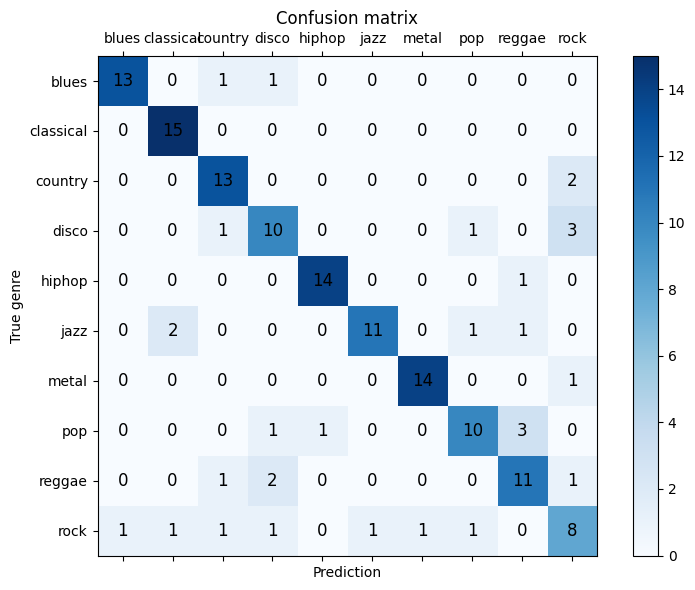

In [11]:
import matplotlib.pyplot as plt
test_accuracy = accuracy_score(y_true, y_pred)
test_precision = precision_score(y_true, y_pred, average='macro')
test_f1 = f1_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision (macro): {test_precision:.4f}")
print(f"F1 Score (macro): {test_f1:.4f}")
print("Confusion Matrix:")

class_names = test_dataset.label_map.keys()

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(conf_matrix, cmap='Blues')
fig.colorbar(cax)
# Dodaj etykiety osi
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

# Dodaj liczby do komórek
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[i])):
        ax.text(j, i, str(conf_matrix[i][j]),
                va='center', ha='center', color='black', fontsize=12)

# Oznaczenia osi
plt.xlabel('Prediction')
plt.ylabel('True genre')
plt.title('Confusion matrix')
plt.tight_layout()
plt.show()


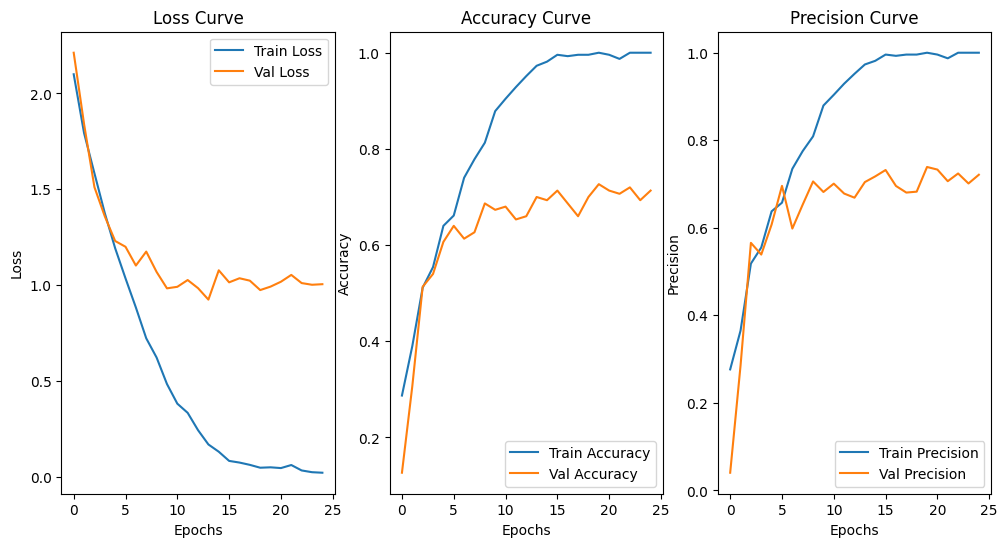

In [12]:
# Plotting the Loss and Accuracy curves
plt.figure(figsize=(12, 6))

# Losses
plt.subplot(1, 3, 1)
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), val_losses, label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy')
plt.plot(range(num_epochs), val_accuracies, label='Val Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Precision
plt.subplot(1, 3, 3)
plt.plot(range(num_epochs), train_precisions, label='Train Precision')
plt.plot(range(num_epochs), val_precisions, label='Val Precision')
plt.title("Precision Curve")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend()

plt.show()

In [13]:

torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_precisions: ': train_precisions,
    'val_precisions': val_precisions,
    'test_accuracy' : test_accuracy,
    'test_precision' : test_precision,
    'test_f1': test_f1,
    'conf_matrix': conf_matrix
}, get_filename_with_date())

In [14]:
'''
torch.save(model.state_dict(), 'model.pth')
'''

"\ntorch.save(model.state_dict(), 'model.pth')\n"

In [15]:
'''

num_classes = 10
model = densenet121()
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
model.load_state_dict(torch.load('model.pth'))
model.eval()
success = 0
val_size = 1
for elem in val_dataset:
    image, label = elem
    with torch.no_grad():
        output = model(image.unsqueeze(0))
    _, predicted = torch.max(output, 1)

    if predicted == label:
        success += 1
    val_size += 1
print(success/val_size)

'''

"\n\nnum_classes = 10\nmodel = densenet121()\nmodel.classifier = nn.Linear(model.classifier.in_features, num_classes)\nmodel.load_state_dict(torch.load('model.pth'))\nmodel.eval()\nsuccess = 0\nval_size = 1\nfor elem in val_dataset:\n    image, label = elem\n    with torch.no_grad():\n        output = model(image.unsqueeze(0))\n    _, predicted = torch.max(output, 1)\n\n    if predicted == label:\n        success += 1\n    val_size += 1\nprint(success/val_size)\n\n"